In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")

In [3]:
#Feature engineering

train['Client Retention Flag']=train['Client Retention Flag'].map({'Yes':1, 'No':0})
train['Flag 3'] = train['Flag 3'].map({'Yes': 1, 'No': 0})
train["Flag 3"].fillna(1, inplace = True) 

train = pd.concat([train,pd.get_dummies(train['Client Contract Starting Month'], prefix='month')],axis=1)
train.drop(['Client Contract Starting Month'],axis=1, inplace=True)

train = pd.concat([train,pd.get_dummies(train['Flag 6'], prefix='sector')],axis=1)
train.drop(['Flag 6'],axis=1, inplace=True)

train['Flag 1']=train['Flag 1'].map({'Multi Year':1,'Single Year':0})
train['Flag 4']=train['Flag 4'].map({'No':0,'Unknown':0.998,'Yes':1})

#train = train.drop(['Client ID'], axis=1)

col = train.loc[: , "Activity 1 Time Period 11":"Activity 1 Time Period 0"]
train['A1_mean'] = col.mean(axis=1)


col = train.loc[: , "Activity 2 Time Period 11":"Activity 2 Time Period 0"]
train['A2_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 3 Time Period 11":"Activity 3 Time Period 0"]
train['A3_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 4 Time Period 11":"Activity 4 Time Period 0"]
train['A4_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 5 Time Period  11":"Activity 5 Time Period  0"]
train['A5_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 6 Time Period  11":"Activity 6 Time Period  0"]
train['A6_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 7 Time Period  11":"Activity 7 Time Period  0"]
train['A7_mean'] = col.mean(axis=1)

col = train.loc[: , "Activity 8 Time Period 11":"Activity 8 Time Period 0"]
train['A8_mean'] = col.mean(axis=1)



train['Activity 1 diff 11']=train['Activity 1 Time Period 11']-train['Activity 1 Time Period 10']
train['Activity 1 diff 10']=train['Activity 1 Time Period 10']-train['Activity 1 Time Period 9']
train['Activity 1 diff 9']=train['Activity 1 Time Period 9']-train['Activity 1 Time Period 8']
train['Activity 1 diff 8']=train['Activity 1 Time Period 8']-train['Activity 1 Time Period 7']
train['Activity 1 diff 7']=train['Activity 1 Time Period 7']-train['Activity 1 Time Period 6']
train['Activity 1 diff 6']=train['Activity 1 Time Period 6']-train['Activity 1 Time Period 5']
train['Activity 1 diff 5']=train['Activity 1 Time Period 5']-train['Activity 1 Time Period 4']
train['Activity 1 diff 4']=train['Activity 1 Time Period 4']-train['Activity 1 Time Period 3']
train['Activity 1 diff 3']=train['Activity 1 Time Period 3']-train['Activity 1 Time Period 2']
train['Activity 1 diff 2']=train['Activity 1 Time Period 2']-train['Activity 1 Time Period 1']
train['Activity 1 diff 1']=train['Activity 1 Time Period 1']-train['Activity 1 Time Period 0']

train = train.drop(['Client ID'], axis=1)
col6 = train.loc[: , "Activity 6 Time Period  11":"Activity 6 Time Period  0"]
col8 = train.loc[: , "Activity 8 Time Period 11":"Activity 8 Time Period 0"]

train=train.drop(col6.columns,axis=1)
train=train.drop(col8.columns,axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


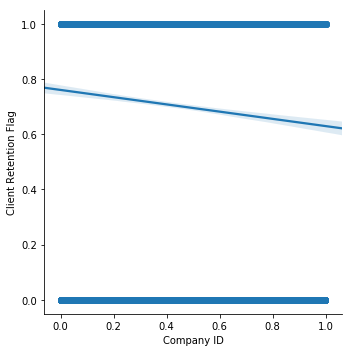

In [28]:
import seaborn as sns
sns.lmplot(x='Company ID',y='Client Retention Flag', data=train,size=5)

In [8]:
#normalizing COLUMN ID
from sklearn import preprocessing

com = train[['Company ID']].values.astype(float)

min_max_scaler = preprocessing.MinMaxScaler()

com_scaled = min_max_scaler.fit_transform(com)

train['Company ID']=com_scaled


In [9]:
x= train.drop(['Client Retention Flag'],axis=1)
y= train['Client Retention Flag']

In [ ]:
#HYPERPARAMETER TUNING
import lightgbm as lgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint

class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train, categorical_columns_indices=None, n_fold=3, seed=2405, early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
class LightGBMOptimizer(ModelOptimizer):
    def evaluate_model(self):
        lgb_dataset = lgb.Dataset(self.X_train, 
                                  self.y_train, 
                                  self.categorical_columns_indices)
        eval_hist = lgb.cv(self.model.get_params(), 
                           lgb_dataset,
                           self.model.n_estimators, 
                           nfold=self.n_fold,
                           seed=self.seed, 
                           stratified=self.is_stratified, 
                           shuffle=self.is_shuffle,
                           early_stopping_rounds=self.early_stopping_rounds, 
                           metrics='auc')
        self.scores = eval_hist
        test_scores = eval_hist[list(eval_hist.keys())[0]]
        best_metric = max(test_scores)
        return 1 - best_metric

import time
greedy_lgbm = lgb.LGBMClassifier(n_estimators=10000,objective='binary',n_jobs=-1)
greedy_lgbm_optimizer = LightGBMOptimizer(greedy_lgbm, x, y)
    

In [ ]:
params_space = [Real(0.01, 0.8, name='learning_rate'),]
greedy_lgbm_optimal_values = greedy_lgbm_optimizer.optimize(params_space)

In [ ]:
params_space = [ Real(1,10,name='max_depth')]
optimal_values = greedy_lgbm_optimizer.optimize(params_space)

In [ ]:
#MODEL
from sklearn.metrics import f1_score
from lightgbm.sklearn import LGBMClassifier

model = LGBMClassifier(max_depth=3, learning_rate=0.03, n_estimators=10000)
model.fit(x, y)



In [66]:
y_pred1=model.predict(x)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [71]:
# calculating accuracy,specificity and sensitivity on training dataset
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y, y_pred1).ravel()
specificity = tn / (tn+fp)
sensitivity= tp/(tp+fn)
accuracy=(tn+tp)/(tn+tp+fp+fn)

In [72]:
specificity

0.9919106317411402

In [73]:
sensitivity

0.9970826580226905

In [74]:
accuracy

0.9955509924709104

In [11]:
#IMPORTING TEST FILE
test1=pd.read_csv('Test.csv')
test=pd.read_csv('Test.csv')


In [12]:
Client_id=test1['Client ID']

In [13]:
from sklearn import preprocessing

test['Flag 1']=test['Flag 1'].map({'Multi Year':1,'Single Year':0})
test['Flag 3'] = test['Flag 3'].map({'Yes': 1, 'No': 0})
test['Flag 4']=test['Flag 4'].map({'No':0,'Unknown':0.998,'Yes':1})

test = pd.concat([test,pd.get_dummies(test['Client Contract Starting Month'], prefix='month')],axis=1)
test.drop(['Client Contract Starting Month'],axis=1, inplace=True)
test = pd.concat([test,pd.get_dummies(test['Flag 6'], prefix='sector')],axis=1)
test.drop(['Flag 6'],axis=1, inplace=True)

com1 = test[['Company ID']].values.astype(float)

cli1= test[['Client ID']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
com1_scaled = min_max_scaler.fit_transform(com1)
cli1_scaled = min_max_scaler.fit_transform(cli1)


test['Company ID']=com1_scaled
test['Client ID']=cli1_scaled


col1 = test.loc[: , "Activity 1 Time Period 11":"Activity 1 Time Period 0"]
test['A1_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 2 Time Period 11":"Activity 2 Time Period 0"]
test['A2_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 3 Time Period 11":"Activity 3 Time Period 0"]
test['A3_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 4 Time Period 11":"Activity 4 Time Period 0"]
test['A4_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 5 Time Period  11":"Activity 5 Time Period  0"]
test['A5_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 6 Time Period  11":"Activity 6 Time Period  0"]
test['A6_mean'] = col1.mean(axis=1) 

col1 = test.loc[: , "Activity 7 Time Period  11":"Activity 7 Time Period  0"]
test['A7_mean'] = col1.mean(axis=1)

col1 = test.loc[: , "Activity 8 Time Period 11":"Activity 8 Time Period 0"]
test['A8_mean'] = col1.mean(axis=1)

test['Activity 1 diff 11']=test['Activity 1 Time Period 11']-test['Activity 1 Time Period 10']
test['Activity 1 diff 10']=test['Activity 1 Time Period 10']-test['Activity 1 Time Period 9']
test['Activity 1 diff 9']=test['Activity 1 Time Period 9']-test['Activity 1 Time Period 8']
test['Activity 1 diff 8']=test['Activity 1 Time Period 8']-test['Activity 1 Time Period 7']
test['Activity 1 diff 7']=test['Activity 1 Time Period 7']-test['Activity 1 Time Period 6']
test['Activity 1 diff 6']=test['Activity 1 Time Period 6']-test['Activity 1 Time Period 5']
test['Activity 1 diff 5']=test['Activity 1 Time Period 5']-test['Activity 1 Time Period 4']
test['Activity 1 diff 4']=test['Activity 1 Time Period 4']-test['Activity 1 Time Period 3']
test['Activity 1 diff 3']=test['Activity 1 Time Period 3']-test['Activity 1 Time Period 2']
test['Activity 1 diff 2']=test['Activity 1 Time Period 2']-test['Activity 1 Time Period 1']
test['Activity 1 diff 1']=test['Activity 1 Time Period 1']-test['Activity 1 Time Period 0']

col61 = test.loc[: , "Activity 6 Time Period  11":"Activity 6 Time Period  0"]
col81 = test.loc[: , "Activity 8 Time Period 11":"Activity 8 Time Period 0"]

test=test.drop(col61.columns,axis=1)
test=test.drop(col81.columns,axis=1)

test = test.drop([ 'Client ID'], axis=1)


In [17]:
#PREDICTION
y_pred1=model.predict(test)
predictions = model.predict(test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
predictions1 = pd.DataFrame(predictions)

sub_file=pd.concat([Client_id, predictions1], axis=1)



In [19]:
sub_file.rename(columns={'Client ID': 'Client ID', 0: 'Client Retention Flag'}, inplace=True)


In [20]:
sub_file['Client Retention Flag']=sub_file['Client Retention Flag'].map({1:'Yes', 0:'No'})


In [21]:
#EXPORTING SUBMISSION FILE
export_excel = sub_file.to_csv(r'C:\Users\Aayush\Desktop\sub56.csv', index = None, header=True)

In [22]:
#IMPORTANCE ANALYSIS

import shap
shap.initjs()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
explainer = shap.TreeExplainer(model)

In [39]:
observations = x.sample(6000, random_state=42)


In [40]:
shap_values = explainer.shap_values(observations)


In [36]:
shap_values.shape

(100, 119)

In [ ]:
x.A1_mean

In [37]:
shap.force_plot(explainer.expected_value, shap_values, features=observations)


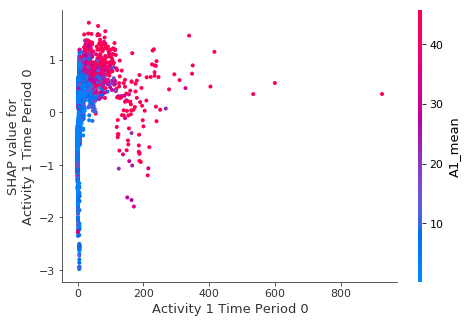

In [61]:
shap.dependence_plot("Activity 1 Time Period 0", shap_values, observations)


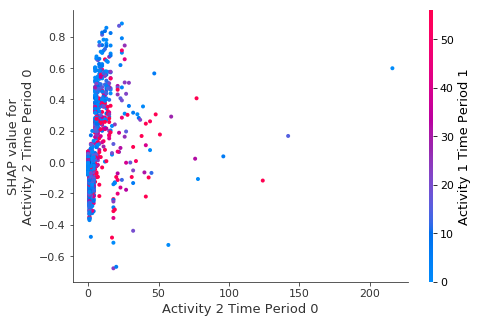

In [62]:
shap.dependence_plot("Activity 2 Time Period 0", shap_values, observations)


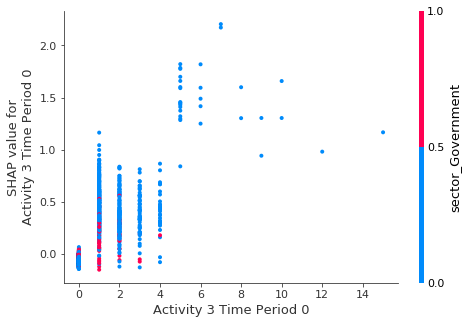

In [63]:
shap.dependence_plot("Activity 3 Time Period 0", shap_values, observations)


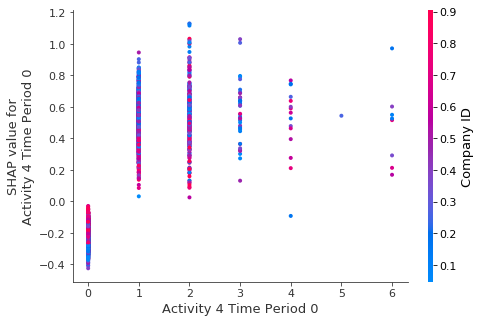

In [64]:
shap.dependence_plot("Activity 4 Time Period 0", shap_values, observations)


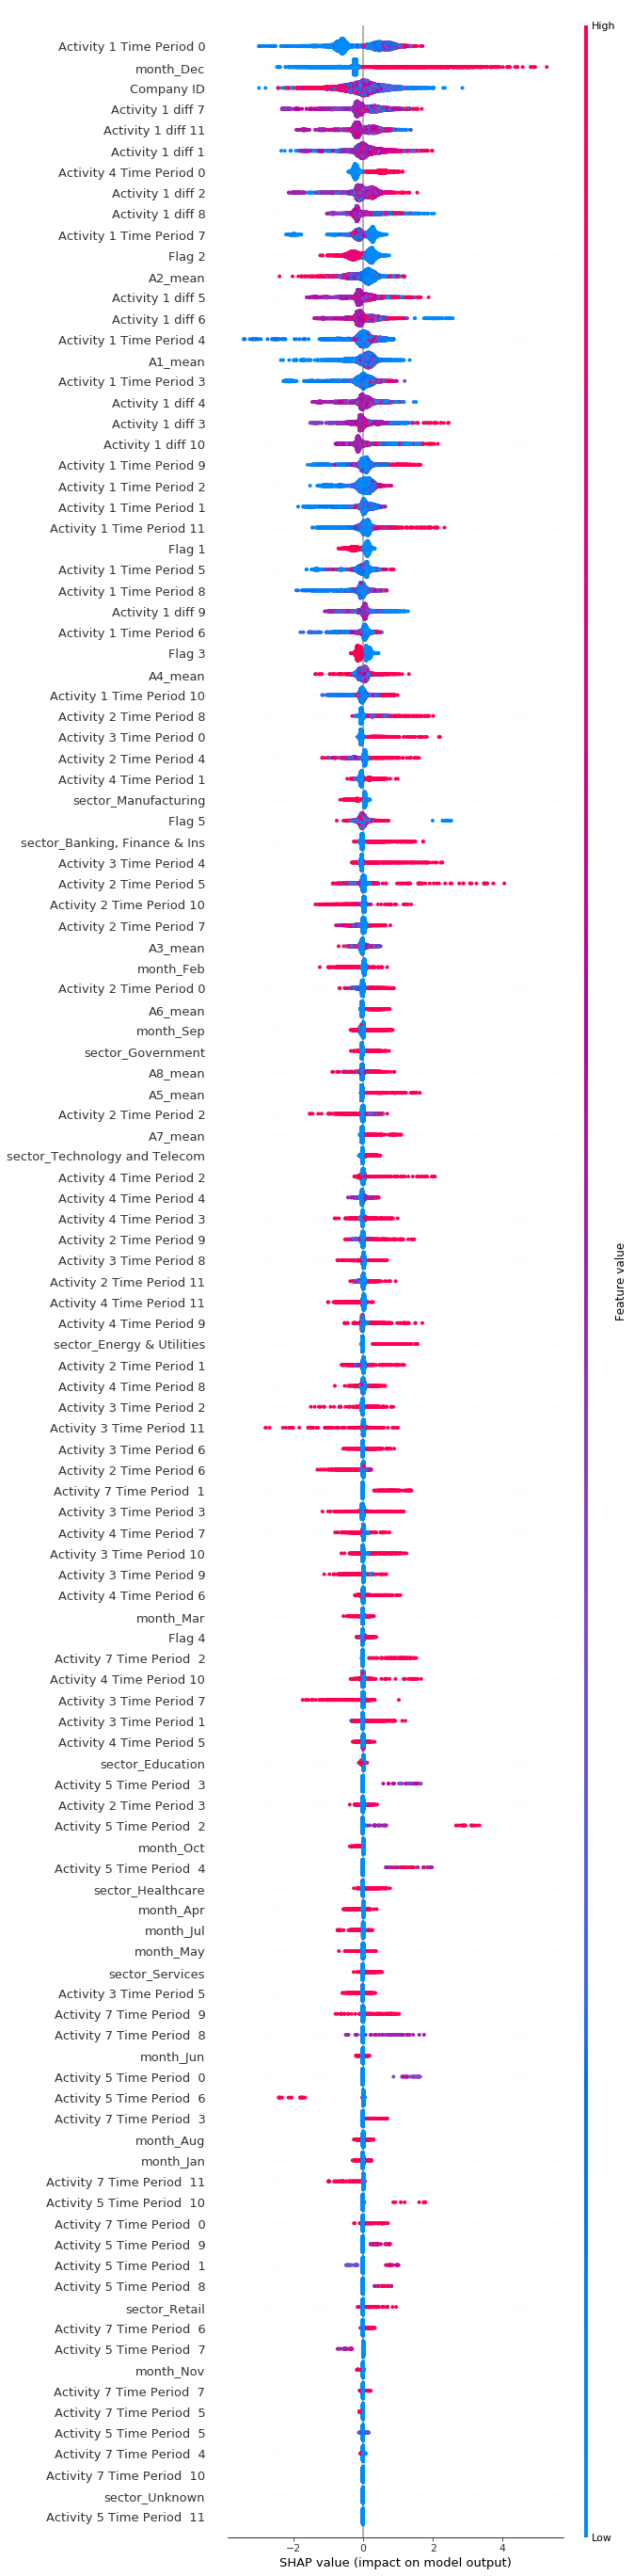

In [59]:
shap.summary_plot(shap_values, features=observations,max_display=130)
